In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_distribution_reconstruction'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
def quantization(x_dd,p_dd):
    x_dd_new = np.arange(np.ceil(x_dd.max())+1)
    p_dd_new = np.zeros([x_dd_new.shape[0]])
    for i in range(p_dd.shape[0]):
        lb = np.floor(x_dd[i]).astype(int)
        ub = np.ceil(x_dd[i]).astype(int)
        if lb==ub:
            p_dd_new[lb] += p_dd[i]
        else:
#             p_dd_new[lb] += p_dd[i] * (x_dd[i]-lb<0.5) 
#             p_dd_new[ub] += p_dd[i] * (x_dd[i]-lb>=0.5) 
              p_dd_new[lb] += p_dd[i] * (ub - x_dd[i]) 
              p_dd_new[ub] += p_dd[i] * (x_dd[i]-lb) 
    return x_dd_new,p_dd_new

# Distribution reconstruction

In [4]:
data = dl.load_10x_4k()
sc.pp.filter_genes(data,min_counts=0.5*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
data_subsample = sd.subsample_anndata(data,Nr/5,Nc)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=810, Nr=3363.40, Nr_bar=4.15
#time start: 0.0s
before cell subsamp (4340, 810)
after cell subsamp (4340, 810)
#time sub-sample cells: 0.0473s
#time sub-sample counts: 9.2698s



In [5]:
gene_list = data.var_names
marker_gene_list = ['IL7R','CD3G','CD3E','CD3D','LCK','NKG7','PRF1','KLRD1','GZMA','HOPX','CST7',\
                   'CD79A','BANK1','IGHD','LINC00926','MS4A1','S100A8','S100A9'\
                   'MNDA','FGL2','CLEC7A','CD6S','IFI30','CD34','GATA2','PRSS57','SMIM24','CYTL1']
gene_list_ = []
for gene in marker_gene_list:
    if gene in gene_list:
        gene_list_.append(gene)
print(gene_list_)

['IL7R', 'CD3G', 'CD3E', 'CD3D', 'LCK', 'NKG7', 'GZMA', 'CST7', 'CD79A', 'MS4A1', 'S100A8', 'FGL2']


In [6]:
def pmf_to_pdf(p,x):
    x_max = x.max()
    x_new = np.linspace(0,x_max,200)
    step = x_new[1]-x_new[0]
    p_new = np.zeros([x_new.shape[0]],dtype=float)
    
    for i_,x_ in enumerate(x):
        w = np.exp(-(x_new-x_)**2*5)
        w = w/np.sum(w)
        p_new += w * p[i_]
    
#     for i_,x_new_ in enumerate(x_new):
#         w = np.exp(-(x_new_-x)**2*100)
#         w = w/np.sum(w)
#         p_new[i_] = w.dot(p)
#     print(np.sum(p_new))
    p_new = p_new/np.sum(p_new)/step
    return p_new,x_new

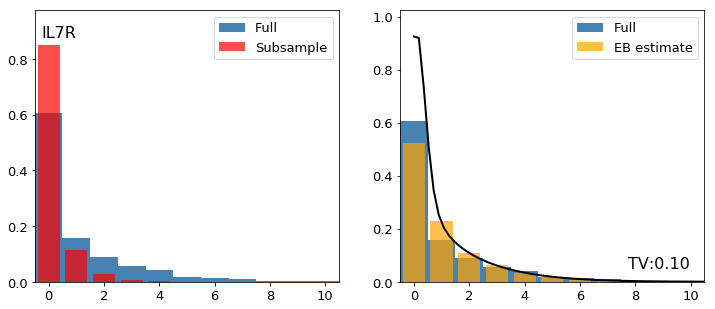

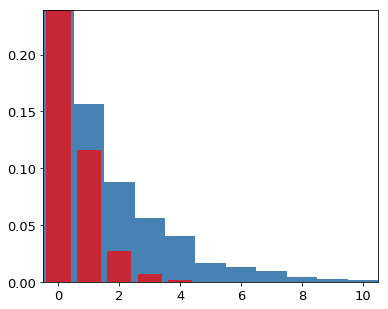

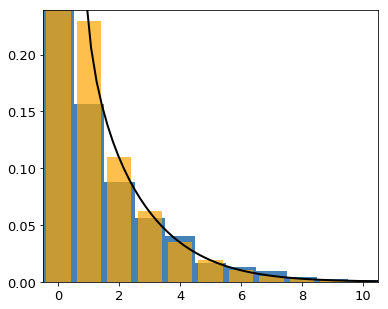

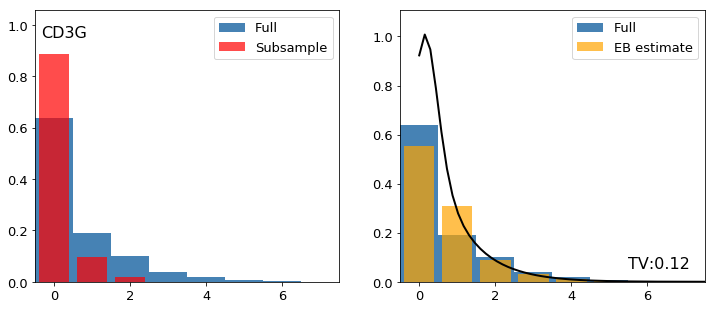

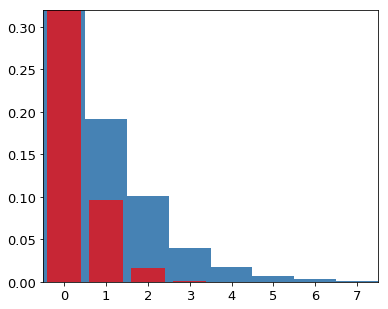

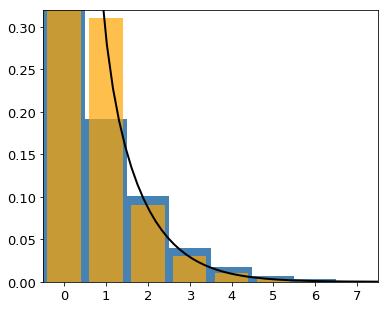

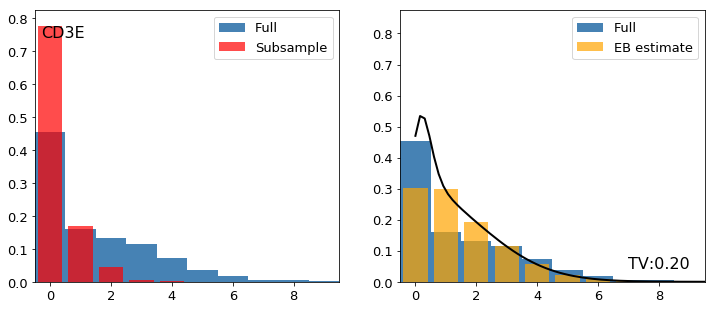

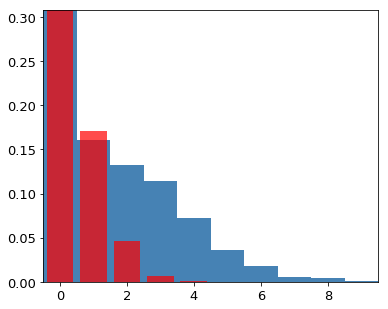

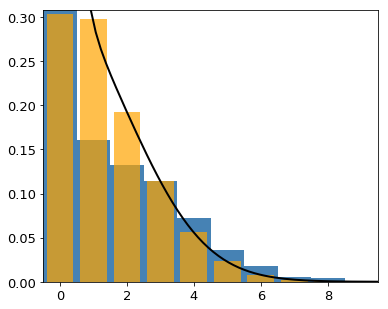

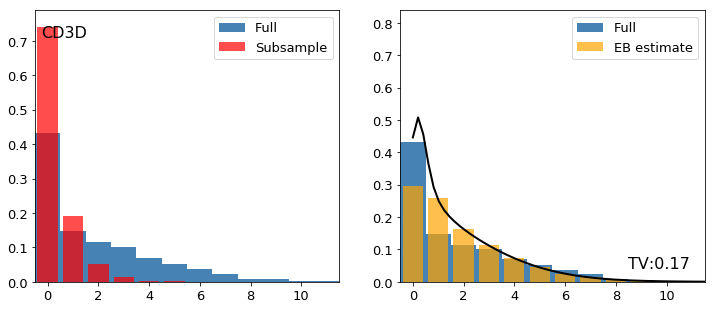

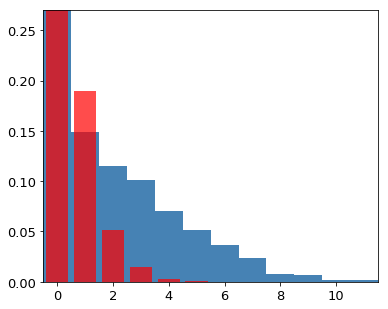

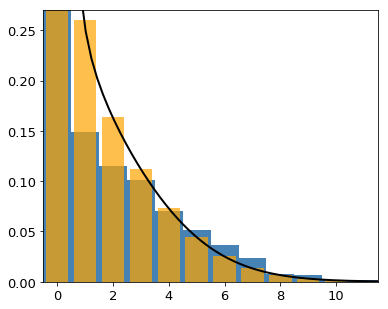

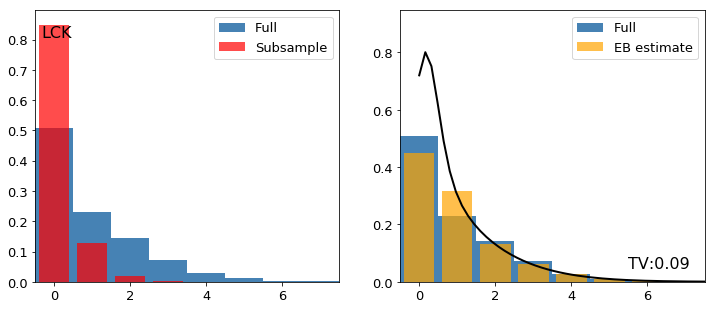

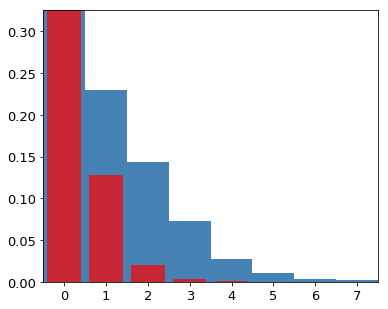

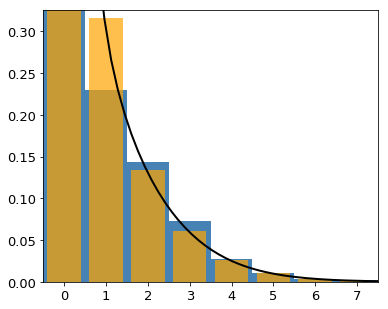

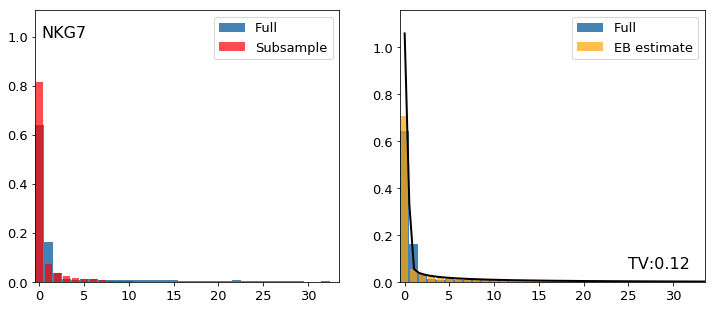

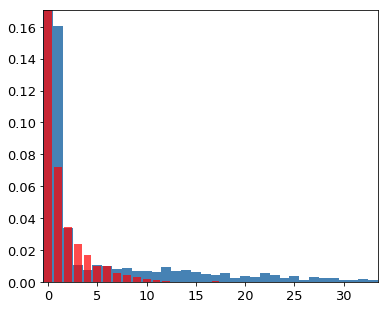

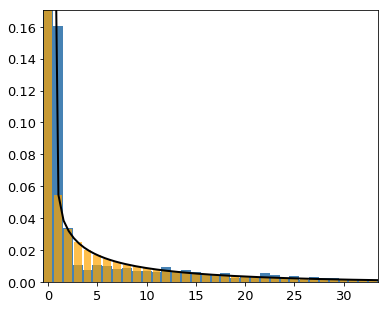

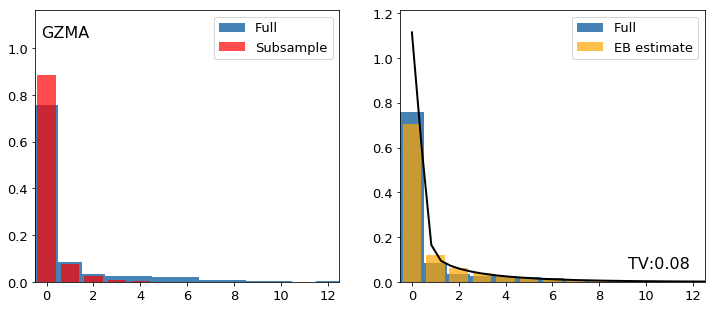

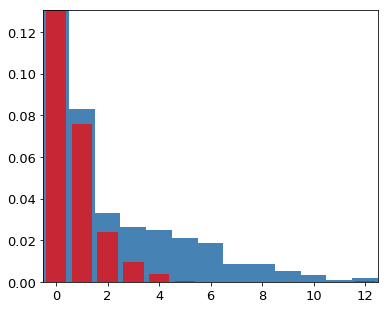

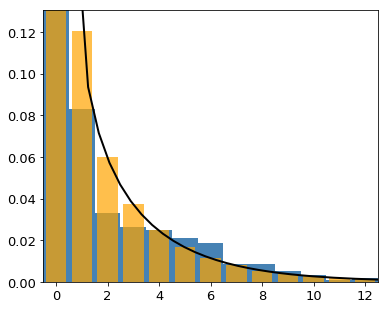

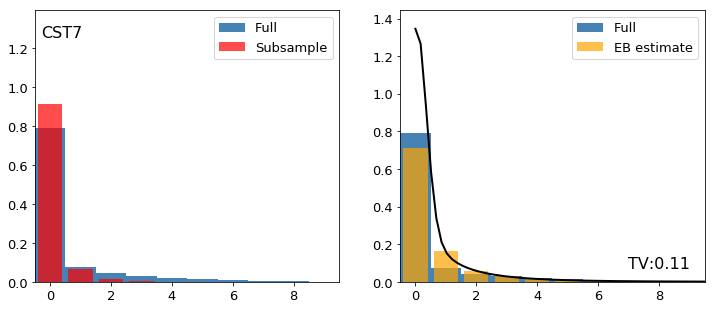

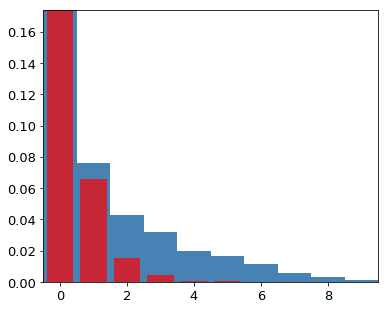

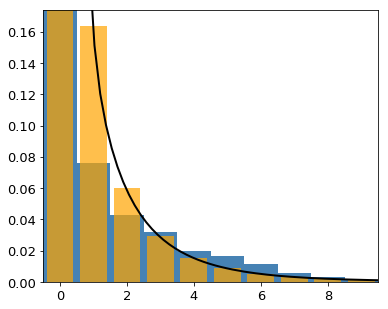

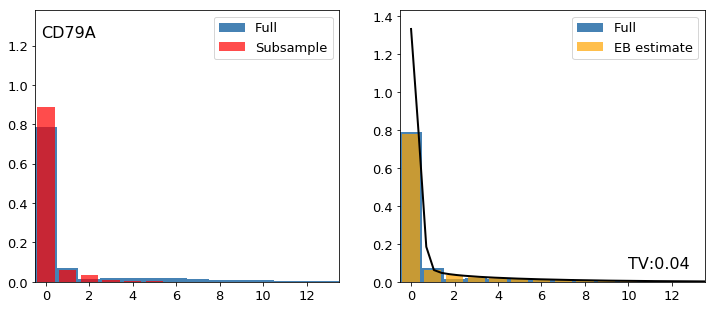

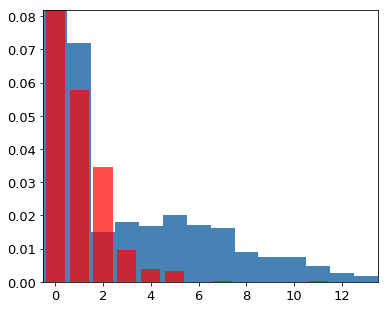

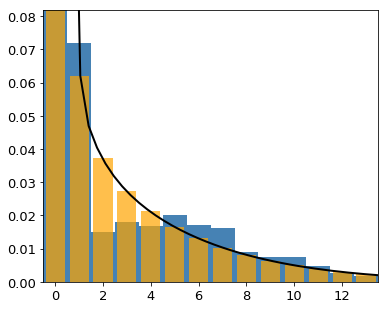

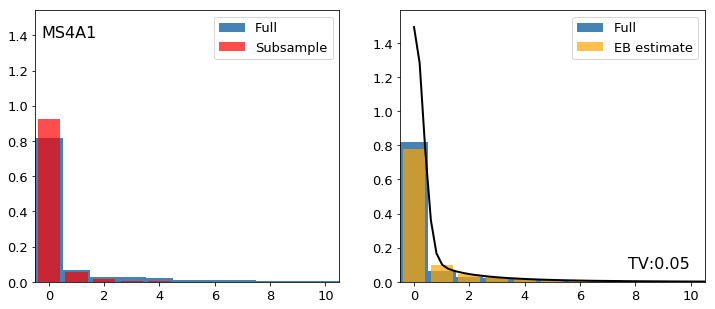

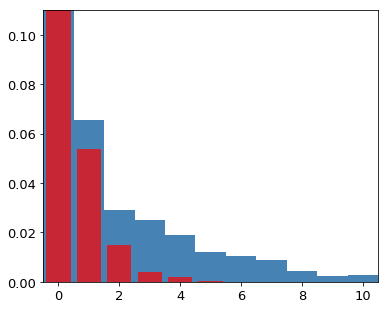

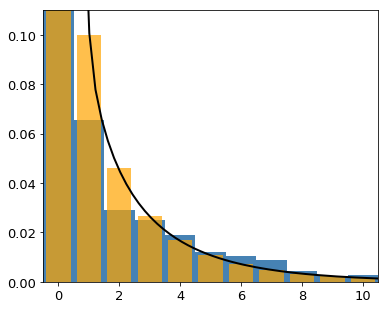

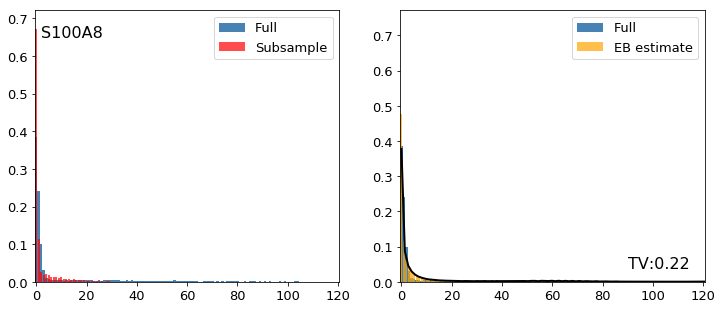

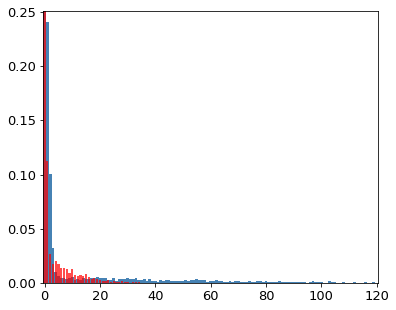

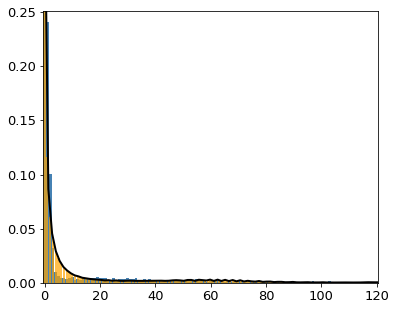

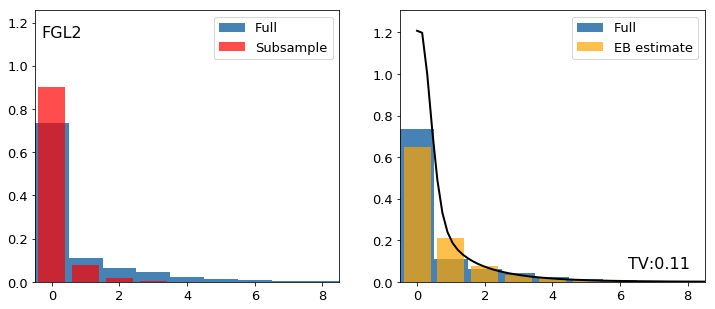

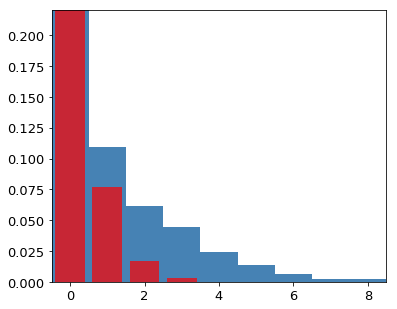

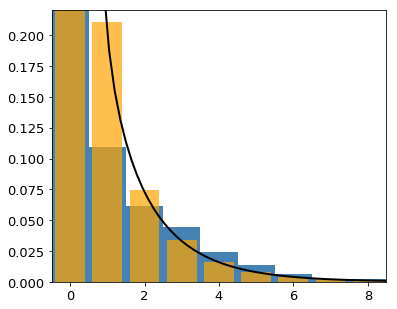

In [7]:
# gene_list_ = ['CD3G','CD3E','CD3D']
# gene_list_ = ['CD3G']
for gene in gene_list_:    
    ## Get the data
    Y = np.array(data[:,gene].X).reshape(-1).astype(int)
    Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)
    Nc = Y.shape[0]
    ## Decide the bins
    y_max = (np.percentile(Y,99)+2).astype(int)
    bins_ = np.linspace(-0.5,y_max+0.5,y_max+2)
    ## Estimation    
    p_sub = np.bincount(Y_sub)
    p_sub = p_sub/np.sum(p_sub)
    x_sub = np.arange(p_sub.shape[0])
    
    p_full = np.bincount(Y)
    p_full = p_full/np.sum(p_full) 
    x_full = np.arange(p_full.shape[0])
    
    p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False) 
    
    ## Computation for panel 2 
    m_full = Y.mean()
    m_dd = p_dd.dot(x_dd)
    x_dd_ = x_dd * m_full / m_dd
    x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
    if p_full.shape[0]<p_dd_new.shape[0]:
        tv_dist = 0.5*np.sum(np.absolute(p_full - p_dd_new[0:p_full.shape[0]]))
    else:
        tv_dist = 0.5*np.sum(np.absolute(p_full[0:p_dd_new.shape[0]] - p_dd_new))
    p_dd_curve,x_dd_curve = pmf_to_pdf(p_dd,x_dd_)
    
    ## determine the figure size 
    y_max = np.max([p_full.max(),p_sub.max(),p_dd_new.max(),p_dd_curve.max()])
    y_max_sub = np.max([p_full[1:].max(),p_sub[1:].max(),p_dd_new[x_dd_new>0.5].max()])
                         
    
    # panel 1
    plt.figure(figsize=[12,5])
    plt.subplot(121)
    plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones([Nc])/Nc,label='Full')
    plt.bar(x_sub,p_sub,color='red',width=0.8, alpha=0.7,label='Subsample')
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,y_max+0.05])
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.annotate(gene,[x_min+0.02*(x_max-x_min),y_max-0.1*(y_max-y_min)])
    plt.legend(fontsize=13)
    
    # panel 2   
    plt.subplot(122)
    plt.hist(Y,bins=bins_,weights = np.ones([Nc])/Nc,color='steelblue',label='Full')
    plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='EB estimate')
    plt.plot(x_dd_curve,p_dd_curve,lw=2,c='k')
    
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,y_max+0.05])
    plt.legend(fontsize=13)
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.annotate('TV:%0.2f'%tv_dist,[x_max-0.25*(x_max-x_min),y_min+0.05*(y_max-y_min)])
    
#     plt.suptitle('%s: mean_count_full=%0.1f, mean_count_sub=%0.1f, EB_error (tv)=%0.2f'\
#                  %(gene, Y.mean(),Y_sub.mean(),tv_dist))
    plt.savefig(output_folder+'/rec_%s.png'%gene)
    plt.savefig(output_folder+'/rec_%s.pdf'%gene)
    plt.show()
    
    ## Zoomed-in figures
    plt.figure(figsize=[6,5])
    plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones([Nc])/Nc,label='Full')
    plt.bar(x_sub,p_sub,color='red',width=0.8, alpha=0.7,label='Subsample')
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,y_max_sub+0.01])
    plt.savefig(output_folder+'/rec_%s_zoomin_1.png'%gene)
    plt.savefig(output_folder+'/rec_%s_zoomin_1.pdf'%gene)
    plt.show()
    
    plt.figure(figsize=[6,5])
    plt.hist(Y,bins=bins_,weights = np.ones([Nc])/Nc,color='steelblue',label='Full')
    plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='EB estimate')
    plt.plot(x_dd_curve,p_dd_curve,lw=2,c='k')
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,y_max_sub+0.01])
    plt.savefig(output_folder+'/rec_%s_zoomin_2.png'%gene)
    plt.savefig(output_folder+'/rec_%s_zoomin_2.pdf'%gene)
    plt.show()

In [ ]:
gene_list_ = ['IL7R']
for gene in gene_list_:
    Y = np.array(data[:,gene].X).reshape(-1).astype(int)
    Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)
    y_max = (np.percentile(Y,99)+2).astype(int)
    bins_ = np.linspace(-0.5,y_max+0.5,y_max+2)
    p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False)
    
    plt.figure(figsize=[18,5])
    plt.subplot(131)
    plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones(Y.shape[0])/Y.shape[0])
    plt.title('Full, mean counts=%0.1f'%Y.mean())
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,1])
    
    p_sub = np.bincount(Y_sub)
    p_sub = p_sub/np.sum(p_sub)
    x_sub = np.arange(p_sub.shape[0])
    plt.bar(x_sub,p_sub,color='red',width=0.8, alpha=0.7,label='Reconstructed')
    
#     plt.hist(Y_sub,bins=bins_,color='steelblue',weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0])
#     plt.title('Subsample, mean counts=%0.1f'%Y_sub.mean())
#     plt.xlim([bins_.min(),bins_.max()])
#     plt.ylim([0,1])
    
    p_full = np.bincount(Y)
    p_full = p_full/np.sum(p_full)    
    m_full = Y.mean()
    m_dd = p_dd.dot(x_dd)
    x_dd_ = x_dd * m_full / m_dd
    x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
    if p_full.shape[0]<p_dd_new.shape[0]:
        tv_dist = 0.5*np.sum(np.absolute(p_full - p_dd_new[0:p_full.shape[0]]))
    else:
        tv_dist = 0.5*np.sum(np.absolute(p_full[0:p_dd_new.shape[0]] - p_dd_new))
    
    plt.subplot(133)
    plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],color='steelblue',alpha=1,label='Orignal')
    plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='Reconstructed')
    plt.title('Reconstruction, total variation=%0.2f'%(tv_dist))
    plt.xlim([bins_.min(),bins_.max()])
    plt.ylim([0,1])
    plt.legend()
    plt.suptitle(gene)
    plt.savefig(output_folder+'/rec_%s.png'%gene)
    plt.savefig(output_folder+'/rec_%s.pdf'%gene)
    plt.show()

# Old code

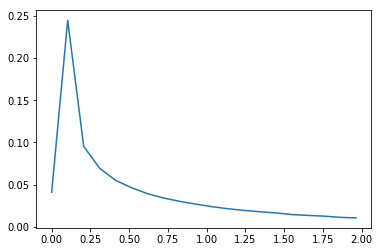

In [281]:
plt.figure()
plt.plot(x_dd_[x_dd_<2],p_dd[x_dd_<2])
plt.show()

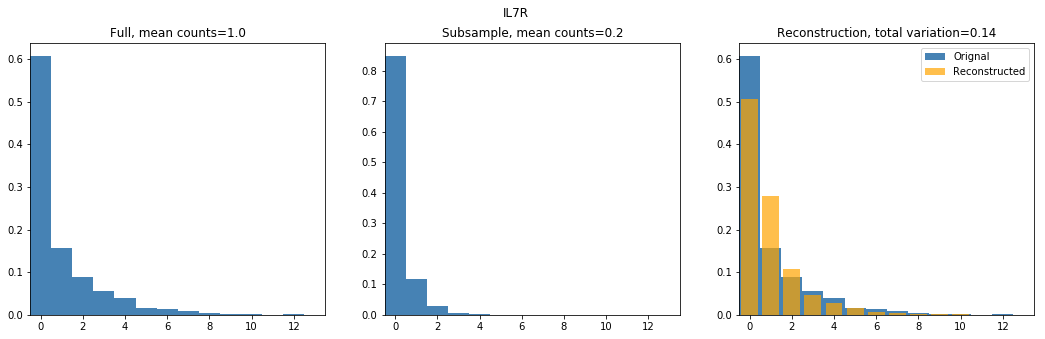

In [282]:
gene = 'IL7R'

Y = np.array(data[:,gene].X).reshape(-1).astype(int)
Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)
y_max = (np.percentile(Y,99)+5).astype(int)
bins_ = np.linspace(-0.5,y_max+0.5,y_max+2)
p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False)

plt.figure(figsize=[18,5])
plt.subplot(131)
plt.hist(Y,bins=bins_,color='steelblue',weights = np.ones(Y.shape[0])/Y.shape[0])
plt.title('Full, mean counts=%0.1f'%Y.mean())
plt.xlim([bins_.min(),bins_.max()])

plt.subplot(132)
plt.hist(Y_sub,bins=bins_,color='steelblue',weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0])
plt.title('Subsample, mean counts=%0.1f'%Y_sub.mean())
plt.xlim([bins_.min(),bins_.max()])

p_full = np.bincount(Y)
p_full = p_full/np.sum(p_full)    
m_full = Y.mean()
m_dd = p_dd.dot(x_dd)
x_dd_ = x_dd * m_full / m_dd
x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
if p_full.shape[0]<p_dd_new.shape[0]:
    tv_dist = 0.5*np.sum(np.absolute(p_full - p_dd_new[0:p_full.shape[0]]))
else:
    tv_dist = 0.5*np.sum(np.absolute(p_full[0:p_dd_new.shape[0]] - p_dd_new))

plt.subplot(133)
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],color='steelblue',alpha=1,label='Orignal')
x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.7,label='Reconstructed')
plt.title('Reconstruction, total variation=%0.2f'%(tv_dist))
plt.xlim([bins_.min(),bins_.max()])
plt.legend()
plt.suptitle(gene)
plt.show()

gamma None
gamma 10
n_degree: 5, c_reg: 0.0001, gamma: 10

alpha [-0.8692742   8.66710302  3.88725987 -5.22799556 -4.2381619  -2.61248261]
--- ccdf ---
>0.05: 21.70%
>0.1: 5.582%
>0.15: 1.522%
>0.2: 0.449%
>0.25: 0.147%
>0.3: 0.055%
>0.35: 0.024%
>0.4: 0.013%


<Figure size 432x288 with 0 Axes>

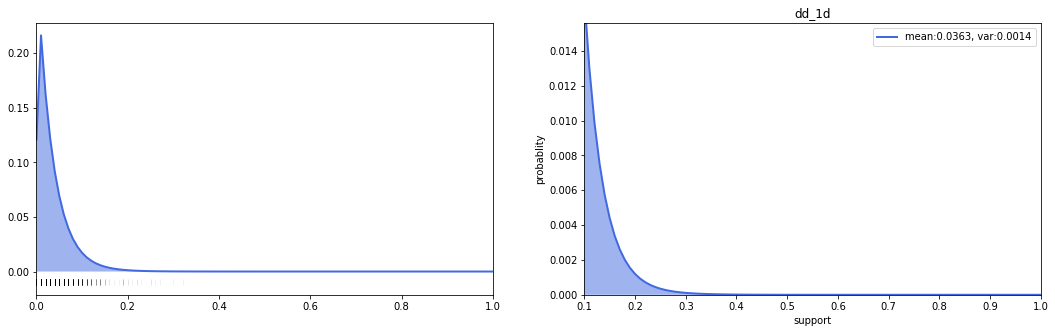

In [172]:
p_full = np.bincount(Y)
p_full = p_full / p_full.sum()
x_full = np.arange(p_full.shape[0])  
p_ml = np.bincount(Y_sub)
p_ml = p_ml / p_ml.sum()
x_ml = np.arange(p_ml.shape[0])            
p_dd,x_dd = sd.dd_distribution(Y_sub,gamma=None,verbose=False)

In [173]:
print('error ml',dist_W1(p_full,p_ml,x_full,x_ml))
print('error dd',dist_W1(p_full,p_dd,x_full,x_dd))

error ml 0.5707132469592806
error dd 0.27133528836948817


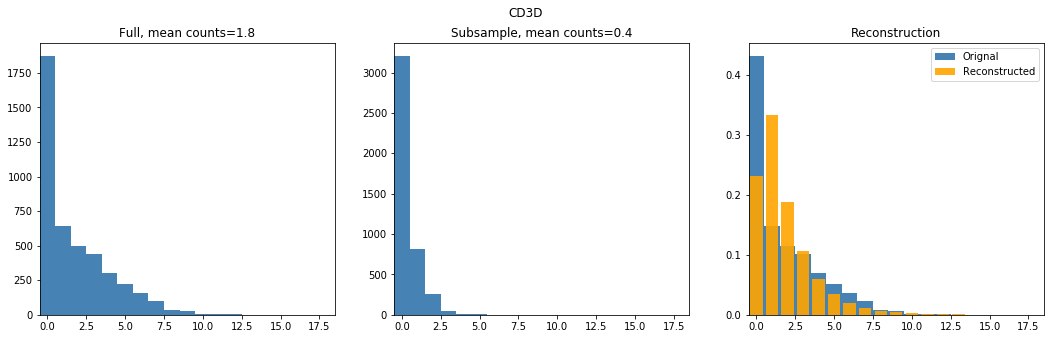

In [235]:
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.hist(Y,bins=bins_,color='steelblue')
plt.title('Full, mean counts=%0.1f'%Y.mean())
plt.xlim([bins_.min(),bins_.max()])

plt.subplot(132)
plt.hist(Y_sub,bins=bins_,color='steelblue')
plt.title('Subsample, mean counts=%0.1f'%Y_sub.mean())
plt.xlim([bins_.min(),bins_.max()])

# plt.show()


m_full = p_full.dot(x_full)
m_dd = p_dd.dot(x_dd)
x_dd_ = x_dd * m_full / m_dd
x_step = x_rec[1]-x_rec[0]
plt.subplot(133)
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],color='steelblue',alpha=1,label='Orignal')
x_dd_new,p_dd_new = quantization(x_dd_,p_dd)
plt.bar(x_dd_new,p_dd_new,color='orange',width=0.8, alpha=0.9,label='Reconstructed')
plt.title('Reconstruction')
plt.xlim([bins_.min(),bins_.max()])
plt.legend()
plt.suptitle(gene)
plt.show()

In [ ]:
mean_full = p_full.dot(x_full)
mean_ml = p_ml.dot(x_ml)
mean_dd = p_dd.dot(x_dd)

plt.figure(figsize=[12,5])
plt.plot(x_full/mean_full,np.cumsum(p_full),label='full')
plt.plot(x_ml/mean_ml,np.cumsum(p_ml),label='ml')
plt.plot(x_dd/mean_dd,np.cumsum(p_dd),label='dd')
plt.legend()
plt.show()

In [189]:
x_dd_

array([ 0.        ,  0.49501676,  0.99003351,  1.48505027,  1.98006703,
        2.47508379,  2.97010054,  3.4651173 ,  3.96013406,  4.45515081,
        4.95016757,  5.44518433,  5.94020108,  6.43521784,  6.9302346 ,
        7.42525136,  7.92026811,  8.41528487,  8.91030163,  9.40531838,
        9.90033514, 10.3953519 , 10.89036865, 11.38538541, 11.88040217,
       12.37541893, 12.87043568, 13.36545244, 13.8604692 , 14.35548595,
       14.85050271, 15.34551947, 15.84053622, 16.33555298, 16.83056974,
       17.3255865 , 17.82060325, 18.31562001, 18.81063677, 19.30565352,
       19.80067028, 20.29568704, 20.79070379, 21.28572055, 21.78073731,
       22.27575407, 22.77077082, 23.26578758, 23.76080434, 24.25582109,
       24.75083785, 25.24585461, 25.74087136, 26.23588812, 26.73090488,
       27.22592164, 27.72093839, 28.21595515, 28.71097191, 29.20598866,
       29.70100542, 30.19602218, 30.69103893, 31.18605569, 31.68107245,
       32.17608921, 32.67110596, 33.16612272, 33.66113948, 34.15

In [ ]:
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.hist(Y,bins=bins_)
plt.title('full %s'%gene)
plt.subplot(212)
plt.hist(Y_sub,bins=bins_)
plt.title('subsample %s'%gene)
plt.show()

In [ ]:
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,15])
plt.subplot(311)
plt.hist(Y,bins=bins_)
plt.title('full %s'%gene)
plt.subplot(312)
plt.hist(Y_sub,bins=bins_)
plt.title('subsample %s'%gene)
# plt.show()


m_full = p_full.dot(x_full)
m_ml = p_ml.dot(x_ml)
m_dd = p_dd.dot(x_dd)
x_rec = x_dd/m_dd*m_full
x_step = x_rec[1]-x_rec[0]
plt.subplot(313)
# plt.hist(Y_sub*m_full/m_ml,bins=bins_,weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0],alpha=0.5,label='sub')
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],alpha=0.5,label='full')
plt.plot(x_rec,p_dd/x_step,linewidth=4,label='dd')
plt.title('gene: %s, Nr_bar = %0.1f'%(gene,Y.mean()))
# plt.xlim([0,80])
plt.legend()
plt.show()

# Simulation

the toy true distribution


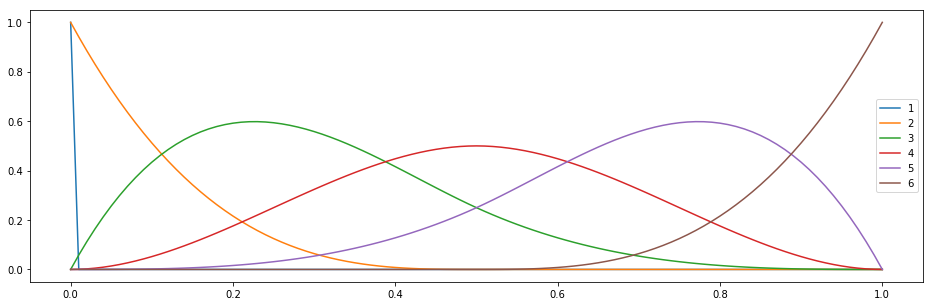

[ 3.    2.4   2.15  1.2  -0.7  -5.  ]
--- ccdf ---
>0.05: 53.03%
>0.1: 44.79%
>0.15: 37.36%
>0.2: 30.76%
>0.25: 24.96%
>0.3: 19.95%
>0.35: 16.47%
>0.4: 12.07%


<Figure size 432x288 with 0 Axes>

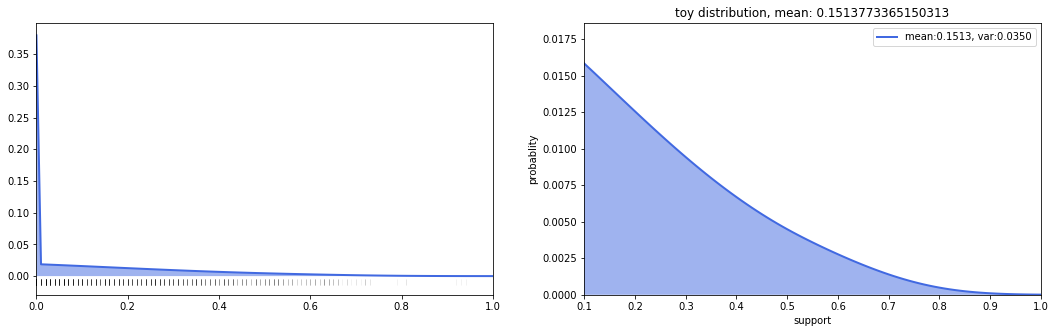

In [2]:
## creating a toy 1d distribution instance
print('the toy true distribution')
p,x_grid=dl.load_1d_toy_spline(verbose=True)
Y,x_samp = sd.Y_gen(p,x_grid,Nc=10000,Nr=5)

n_degree: 5, c_reg: 1e-05, gamma: 5

--- ccdf ---
>0.05: 52.44%
>0.1: 43.71%
>0.15: 35.38%
>0.2: 28.05%
>0.25: 21.79%
>0.3: 16.63%
>0.35: 12.53%
>0.4: 9.377%


<Figure size 432x288 with 0 Axes>

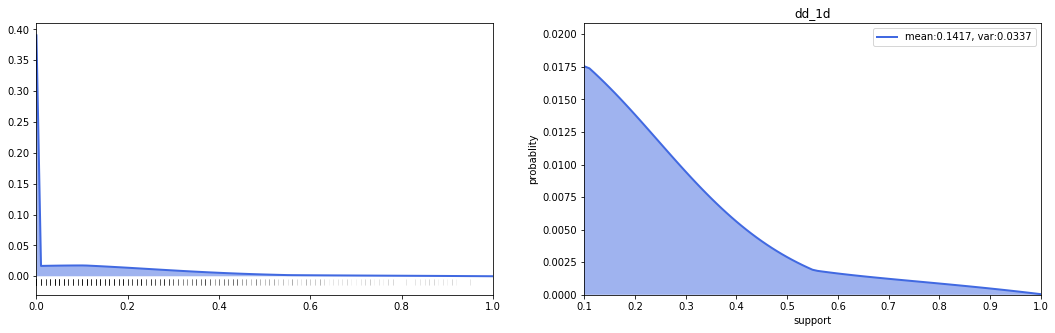

In [4]:
p_hat,x_hat = sd.dd_distribution(Y,gamma=5,verbose=True,c_reg=1e-5)

In [5]:
dist_W1(p,p_hat,x_grid,x_hat)

0.00891005758688427

# Some real data

In [8]:
data = dl.load_10x_4k()
sc.pp.filter_genes(data,min_counts=1*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
data_subsample = sd.subsample_anndata(data,Nr/5,Nc)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=394, Nr=3075.8, Nr_bar=7.8
#time start: 0.0s
before cell subsamp (4340, 394)
after cell subsamp (4340, 394)
#time sub-sample cells: 0.0128s
#time sub-sample counts: 4.8171s



In [6]:
gene = 'CD3E'
Y = np.array(data[:,gene].X).reshape(-1).astype(int)
Y_sub = np.array(data_subsample[:,gene].X).reshape(-1).astype(int)

NameError: name 'data' is not defined

n_degree: 5, c_res: 2, c_reg: 0.0001, gamma: 8

8.830460231950578e-05
8.165556184548228e-05
7.917982787324441e-05
7.745101933427789e-05
7.608846934363673e-05
7.497332859558928e-05
7.404708298613607e-05
7.326837425493602e-05
7.260580486677628e-05
7.203568937211668e-05
7.154021070236641e-05
7.110586130270946e-05
7.072226015497932e-05
7.038130441435076e-05
7.007657192176956e-05
--- ccdf ---
>0.05: 29.34%
>0.1: 9.721%
>0.15: 3.272%
>0.2: 1.137%
>0.25: 0.414%
>0.3: 0.158%
>0.35: 0.081%
>0.4: 0.037%


<Figure size 432x288 with 0 Axes>

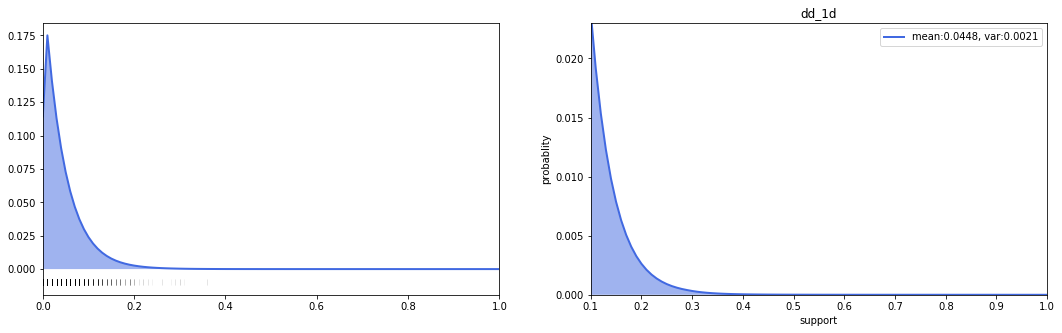

In [331]:
p_dd,x_dd = sd.dd_distribution(Y_sub,verbose=True,c_reg=1e-4)

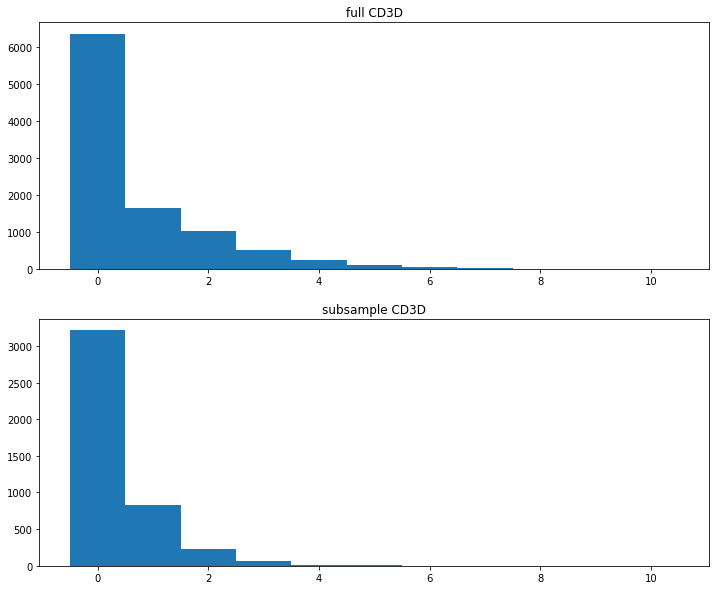

In [324]:
bins_ = np.linspace(-0.5,Y.max()+0.5,Y.max()+2)
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.hist(Y,bins=bins_)
plt.title('full %s'%gene)
plt.subplot(212)
plt.hist(Y_sub,bins=bins_)
plt.title('subsample %s'%gene)
plt.show()

In [325]:
bins_

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5])

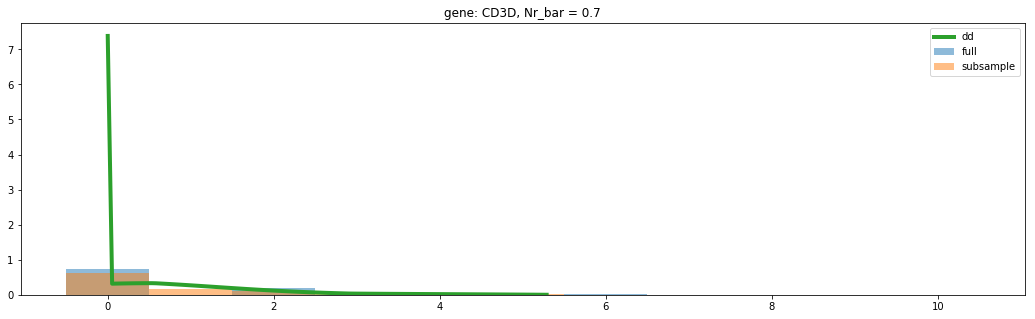

In [326]:
m_full = Y.mean()
m_sub = Y_sub.mean()
m_hat = p_hat.dot(x_hat)
x_rec = x_hat/m_hat*m_full
x_step = x_rec[1]-x_rec[0]
plt.figure(figsize=[18,5])
plt.hist(Y_sub*m_full/m_sub,bins=bins_,weights = np.ones(Y_sub.shape[0])/Y_sub.shape[0],alpha=0.5,label='full')
plt.hist(Y,bins=bins_,weights = np.ones(Y.shape[0])/Y.shape[0],alpha=0.5,label='subsample')
plt.plot(x_rec,p_hat/x_step,linewidth=4,label='dd')
plt.title('gene: %s, Nr_bar = %0.1f'%(gene,Y.mean()))
# plt.xlim([0,80])
plt.legend()
plt.show()

In [327]:
p_ml = np.bincount(Y)
p_ml = p_ml / p_ml.sum()
x_ml = np.arange(p_ml.shape[0])            
p_dd,x_dd = sd.dd_distribution(Y,gamma=None,verbose=False,c_reg=1e-3)

0.00018145484177047768
0.00016425013789006678
0.0001548787715457063
0.00014853868344228286
0.00014385945273024813
0.00013931651568238024
0.00013650061444745235
0.00013413043984081545
0.00013210512797844691
0.00013035001178696563
0.00012881053692630402
0.00012744642669662465
0.00012622731923155536
0.00012512984044481213
0.00012413565148628705
0.00012323012256191683
0.0001224014113594745
0.00012163980815515351
0.00012093726080033085
0.00012028702377980959
0.00011968339462312095
0.00011912151297171557
0.00011859720534892633
0.00011810686377748199
0.00011764734981318296
0.00011721591790546658
0.0001168101536248649
0.00011642792344835174
0.0001160673336182452
0.00011572669618895961


In [328]:
mean_ml = p_ml.dot(x_ml)
mean_dd = p_dd.dot(x_dd)
mean_ = p.dot(x_grid)
x_ml = x_ml * mean_ / mean_ml
x_dd = x_dd * mean_ / mean_dd
err_ml = dist_W1(p,p_ml,x_grid,x_ml)
err_dd = dist_W1(p,p_dd,x_grid,x_dd)

In [329]:
err_ml

0.05170237991053862

In [330]:
err_dd

0.007400485511104311